In [1]:
import numpy as np
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as td
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class CNNAE(nn.Module):
    def __init__(self):
        super(CNNAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(32, 64, 7),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.PReLU(),
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.PReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


if __name__ == "__main__":
    # %%
    learning_rate = 0.0005
    batch_size = 64
    num_epochs = 100

    #DEVICE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 初始化网络
    model = CNNAE().to(device)
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练数据加载器
    data = np.load("data4D.npy", allow_pickle=True)
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    train_data = torch.from_numpy(train_data).to(device)
    test_data = torch.from_numpy(test_data).to(device)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)



    wandb.init(
        # set the wandb project where this run will be logged
        project="MagAE_2D",

        # track hyperparameters and run metadata
        config={
            "learning_rate": learning_rate,
            "architecture": "CNN",
            "dataset": "2DMag",
            "epochs": num_epochs,
            "batch_size": batch_size,
        })


    for epoch in range(num_epochs):
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()

        wandb.log({"Epochs": epoch + 1, "loss": loss.item()})

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    with torch.no_grad():
        test_loss = 0
        for data in test_loader:
            data = data.to(device)
            recon_batch = model(data)
            test_loss += criterion(recon_batch, data).item()
        test_loss /= len(test_loader.dataset)
        wandb.log({"test_loss": test_loss})
        print(f"Test Loss: {test_loss:.4f}")

    wandb.finish()

Using device: cuda


wandb: Currently logged in as: dongtianchi (te-st). Use `wandb login --relogin` to force relogin


Epoch [1/100], Loss: 0.0475
Epoch [2/100], Loss: 0.0389
Epoch [3/100], Loss: 0.0332
Epoch [4/100], Loss: 0.0299
Epoch [5/100], Loss: 0.0278
Epoch [6/100], Loss: 0.0216
Epoch [7/100], Loss: 0.0186
Epoch [8/100], Loss: 0.0146
Epoch [9/100], Loss: 0.0165
Epoch [10/100], Loss: 0.0126
Epoch [11/100], Loss: 0.0094
Epoch [12/100], Loss: 0.0120
Epoch [13/100], Loss: 0.0108
Epoch [14/100], Loss: 0.0107
Epoch [15/100], Loss: 0.0094
Epoch [16/100], Loss: 0.0081
Epoch [17/100], Loss: 0.0083
Epoch [18/100], Loss: 0.0081
Epoch [19/100], Loss: 0.0084
Epoch [20/100], Loss: 0.0075
Epoch [21/100], Loss: 0.0081
Epoch [22/100], Loss: 0.0067
Epoch [23/100], Loss: 0.0072
Epoch [24/100], Loss: 0.0059
Epoch [25/100], Loss: 0.0050
Epoch [26/100], Loss: 0.0058
Epoch [27/100], Loss: 0.0062
Epoch [28/100], Loss: 0.0052
Epoch [29/100], Loss: 0.0056
Epoch [30/100], Loss: 0.0040
Epoch [31/100], Loss: 0.0049
Epoch [32/100], Loss: 0.0051
Epoch [33/100], Loss: 0.0043
Epoch [34/100], Loss: 0.0058
Epoch [35/100], Loss: 0

Epochs,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁
Epochs,100
loss,0.00294
test_loss,3e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: axes don't match array

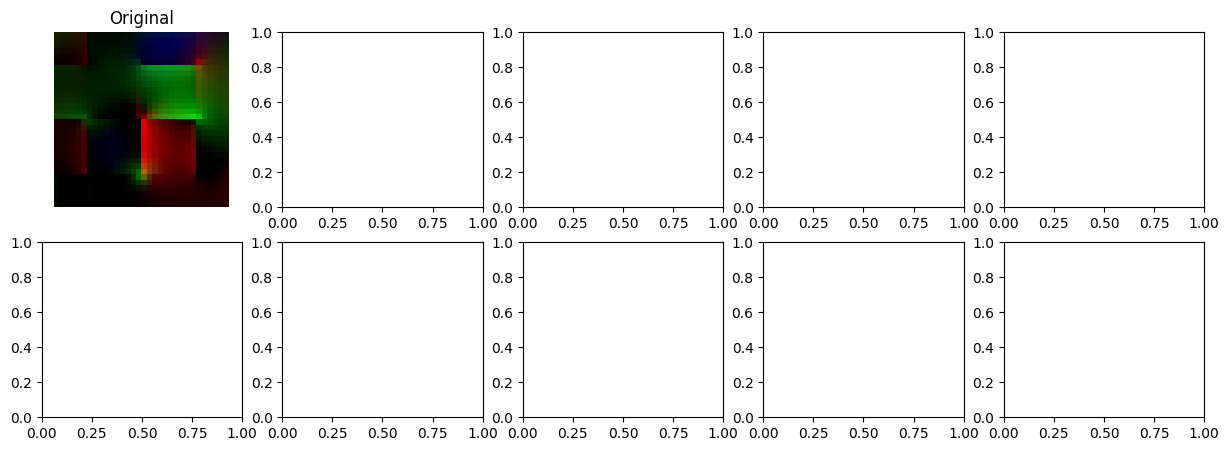

In [2]:
def plot_images(original, reconstructed):
    fig, axes = plt.subplots(nrows=2, ncols=len(original), figsize=(15, 5))
    for i in range(len(original)):
        axes[0, i].imshow(np.transpose(original[i].cpu().detach().numpy(), (1, 2, 0)), cmap="viridis")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")
        axes[1, i].imshow(np.transpose(reconstructed[i].cpu().detach().numpy(), (1, 2, 0)), cmap="viridis")
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

# 从测试集中选取一些样本
sample_indices = [0, 1, 2, 3, 4]  # 你可以根据需要更改这些索引
samples = [test_data[i] for i in sample_indices]

# 使用模型进行预测
model.eval()  # 将模型设置为评估模式
with torch.no_grad():
    reconstructed_samples = [model(sample.unsqueeze(0).to(device)) for sample in samples]

# 绘制原始输入和预测结果
plot_images(samples, reconstructed_samples)